In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import gc
import os
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
from models import *
import torch.nn.functional as F
from i2sb.runner import Runner
from Datasets import LatentSpaceDataset
from utils import *

SEED = 1234
torch.manual_seed(SEED)
np.random.seed(SEED)

# Optional (for reproducibility in CUDA):
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

/Users/evanwu/ml-mangrove/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Our Diffusion Layer is trained on a NAIP aerial imagery, which is 1m/pixel resolution imagery taken all over the US. It learns to map LR feature spaces of Sentinel-2 to the HR feature spaces of NAIP.

We now benchmark the trained Diffusion Layer's ability to map LR features spaces of Sentinel-2 to the HR feature spaces of 1mDrone from our Jamaica/Mexico expeditions.

In [2]:
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.\n")
else:
    DEVICE = torch.device("cpu")
    print("WARNING: No GPU found. Defaulting to CPU.")

TRAINED_DIFFUSION_RUNNER_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/results/test/model_001000.pt' # opt.load variable
TRAINED_DIFFUSION_RUNNER = torch.load(TRAINED_DIFFUSION_RUNNER_PATH, map_location=DEVICE) # contains keys: ['net', 'ema', 'optimizer', 'sched']

PRETRAINED_RNUN_NOSKIP_PATH = '/Users/evanwu/Downloads/224_moco_resnet18_noskip.pth' # load in center layer from here
PRETRAINED_RNUN_NOSKIP = torch.load(PRETRAINED_RNUN_NOSKIP_PATH, map_location=DEVICE)

JAMAICA_RGB_LATENT_PATH = 'data/one_meter_drone/224final_latent_dataset_drone_512.npy'
JAMAICA_SATELLITE_LATENT_PATH = 'data/one_meter_drone/224final_latent_dataset_satellite_512.npy'

NAIP_RGB_LATENT_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224final_straight_latent_drone_512.npy'
NAIP_SATELLITE_LATENT_PATH = '/Users/evanwu/ml-mangrove/Super Resolution/Schrodinger Diffusion/data/one_meter_drone/224final_straight_latent_satellite_512.npy'

PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE = 0.6512
PRETRAINED_RGB_MOCO_WEIGHT_FIRST_VALUE = 0.0596
PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE = 0.0150

INTERVAL = 100 # number of reconstruction time intervals
# LOG_STEPS = [0, 111, 222, 333, 444, 554, 665, 776, 887, 998] # hardcoded - based on opt.interval of trained diffuser
LOG_STEPS = [0, 11, 22, 33, 44, 54, 65, 76, 87, 98] # hardcoded - based on opt.interval of trained diffuser

Using Apple Metal Performance Shaders (MPS) device.



In [3]:
# log layers of TRAINED_DIFFUSION_RUNNER['net']
for key in TRAINED_DIFFUSION_RUNNER['net'].keys():
  print(key)

encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.bn1.running_mean
encoder.4.0.bn1.running_var
encoder.4.0.bn1.num_batches_tracked
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.bn2.running_mean
encoder.4.0.bn2.running_var
encoder.4.0.bn2.num_batches_tracked
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.bn1.running_mean
encoder.4.1.bn1.running_var
encoder.4.1.bn1.num_batches_tracked
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.bn2.running_mean
encoder.4.1.bn2.running_var
encoder.4.1.bn2.num_batches_tracked
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.bn1.running_mean
encoder.5.0.bn1.running_var
encoder.5.0.bn1.num_batches_tracked
encoder.5.0.conv2.weight
encoder.5.0.bn2.weight
encoder.5.0.bn2.bi

In [4]:
# log layers of PRETRAINED_RNUN_NOSKIP
for key in PRETRAINED_RNUN_NOSKIP.keys():
  print(key)

encoder.0.weight
encoder.1.weight
encoder.1.bias
encoder.1.running_mean
encoder.1.running_var
encoder.1.num_batches_tracked
encoder.4.0.conv1.weight
encoder.4.0.bn1.weight
encoder.4.0.bn1.bias
encoder.4.0.bn1.running_mean
encoder.4.0.bn1.running_var
encoder.4.0.bn1.num_batches_tracked
encoder.4.0.conv2.weight
encoder.4.0.bn2.weight
encoder.4.0.bn2.bias
encoder.4.0.bn2.running_mean
encoder.4.0.bn2.running_var
encoder.4.0.bn2.num_batches_tracked
encoder.4.1.conv1.weight
encoder.4.1.bn1.weight
encoder.4.1.bn1.bias
encoder.4.1.bn1.running_mean
encoder.4.1.bn1.running_var
encoder.4.1.bn1.num_batches_tracked
encoder.4.1.conv2.weight
encoder.4.1.bn2.weight
encoder.4.1.bn2.bias
encoder.4.1.bn2.running_mean
encoder.4.1.bn2.running_var
encoder.4.1.bn2.num_batches_tracked
encoder.5.0.conv1.weight
encoder.5.0.bn1.weight
encoder.5.0.bn1.bias
encoder.5.0.bn1.running_mean
encoder.5.0.bn1.running_var
encoder.5.0.bn1.num_batches_tracked
encoder.5.0.conv2.weight
encoder.5.0.bn2.weight
encoder.5.0.bn2.bi

In [5]:
from utils import JupyterArgParser
from pathlib import Path

# ========= global settings =========
# Taken from i2sb paper with minor changes

RESULT_DIR = Path("results")

# --------------- basic ---------------
parser = JupyterArgParser()
parser.add_argument("--seed",           type=int,   default=0)
parser.add_argument("--name",           type=str,   default=None,        help="experiment ID")
parser.add_argument("--ckpt",           type=str,   default=None,        help="resumed checkpoint name")
parser.add_argument("--device",         type=str,   default=DEVICE,      help="type of device to use for training")
parser.add_argument("--gpu",            type=int,   default=None,        help="set only if you wish to run on a particular GPU")

# --------------- model ---------------
parser.add_argument("--image-size",     type=int,   default=224)
parser.add_argument("--t0",             type=float, default=1e-4,        help="sigma start time in network parametrization")
parser.add_argument("--T",              type=float, default=1.,          help="sigma end time in network parametrization")
parser.add_argument("--interval",       type=int,   default=INTERVAL,        help="number of interval")
parser.add_argument("--beta-max",       type=float, default=0.3,         help="max diffusion for the diffusion model")
parser.add_argument("--beta-schedule",  type=str,   default="i2sb",    help="schedule for beta")
parser.add_argument("--ot-ode",         action="store_true",             help="use OT-ODE model")
parser.add_argument("--clip-denoise",   action="store_true",             help="clamp predicted image to [-1,1] at each")
parser.add_argument("--use-fp16",       action="store_true",             help="use fp16 for training")
parser.add_argument("diffusion-type",   type=str,   default="schrodinger_bridge",      help="type of diffusion model")

# --------------- optimizer and loss ---------------
parser.add_argument("--batch-size",     type=int,   default=256)
parser.add_argument("--microbatch",     type=int,   default=4,           help="accumulate gradient over microbatch until full batch-size")
parser.add_argument("--num-itr",        type=int,   default=10001,     help="training iteration")
parser.add_argument("--lr",             type=float, default=5e-5,        help="learning rate")
parser.add_argument("--lr-gamma",       type=float, default=0.99,        help="learning rate decay ratio")
parser.add_argument("--lr-step",        type=int,   default=1000,        help="learning rate decay step size")
parser.add_argument("--l2-norm",        type=float, default=0.0)
parser.add_argument("--ema",            type=float, default=0.99)

# --------------- path and logging ---------------
parser.add_argument("--dataset-dir",    type=Path,  default="/dataset",  help="path to LMDB dataset")
parser.add_argument("--log-dir",        type=Path,  default=".log",      help="path to log std outputs and writer data")
parser.add_argument("--log-writer",     type=str,   default=None,        help="log writer: can be tensorbard, wandb, or None")
parser.add_argument("--wandb-api-key",  type=str,   default=None,        help="unique API key of your W&B account; see https://wandb.ai/authorize")
parser.add_argument("--wandb-user",     type=str,   default=None,        help="user name of your W&B account")
parser.add_argument("--ckpt-path",      type=Path,  default=None,        help="path to save checkpoints")
parser.add_argument("--load",           type=Path,  default=TRAINED_DIFFUSION_RUNNER_PATH,        help="path to load checkpoints")
parser.add_argument("--unet_path",      type=str,   default=None,        help="path of UNet model to load for training")

# --------------- distributed ---------------
parser.add_argument("--local-rank",     type=int,   default=0)
parser.add_argument("--global-rank",    type=int,   default=0)
parser.add_argument("--global-size",    type=int,   default=1)

opt = parser.get_options()
# ========= path handle =========
opt.name = "test"
os.makedirs(opt.log_dir, exist_ok=True)
opt.ckpt_path = RESULT_DIR / opt.name if opt.name else RESULT_DIR / "temp"
os.makedirs(opt.ckpt_path, exist_ok=True)

# ========= auto assert =========
assert opt.batch_size % opt.microbatch == 0, f"{opt.batch_size=} is not dividable by {opt.microbatch}!"


run = Runner(opt)

dummy input: latent space channels=512
Loaded 'net' and 'ema' from checkpoint path
Built schrodinger_bridge Diffusion Model with 100 steps and i2sb beta schedule!


In [6]:
# manually load in run.net diffusion layer and center layer
state_dict = run.net.state_dict()

diffusion_prefixes = [
    'diffuser'
]
print(f"From TRAINED_DIFFUSION_RUNNER['net']")
for k, v in TRAINED_DIFFUSION_RUNNER['net'].items():
    if any(k.startswith(prefix) for prefix in diffusion_prefixes):
        print(f"\tLoad {k} in to ResNet UNet Diffusion state dict")
        state_dict[k] = v

center_prefixes = [
    'center'
]
print(f"From PRETRAINED_RNUN_NOSKIP")
for k, v in PRETRAINED_RNUN_NOSKIP.items():
    if any(k.startswith(prefix) for prefix in center_prefixes):
        print(f"\tLoad {k} in to ResNet UNet Diffusion state dict")
        state_dict[k] = v

run.net.load_state_dict(state_dict) # load in updated dict to model
print("✅ Loaded state_dict into run.net")





loaded_dict = run.net.state_dict()

# sanity check that the first weight value matches for CENTER
assert math.isclose(loaded_dict['center.decoder.0.weight'].flatten()[0].item(), PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['center.decoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE={PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE}"
print(loaded_dict['center.decoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_CENTER_DECODER_0_WEIGHT_FIRST_VALUE)

# sanity check that the first weight value matches for ALL_MOCO
assert math.isclose(loaded_dict['encoder.0.weight'].flatten()[0].item(), PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE, abs_tol=1e-4), f"first weight from center.decoder.0.weight={loaded_dict['encoder.0.weight'].flatten()[0].item()} does not equal PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE={PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE}"
print(loaded_dict['encoder.0.weight'].flatten()[0].item() , 'and', PRETRAINED_ALL_MOCO_WEIGHT_FIRST_VALUE)

From TRAINED_DIFFUSION_RUNNER['net']
	Load diffuser.timestep_embed.0.weight in to ResNet UNet Diffusion state dict
	Load diffuser.timestep_embed.0.bias in to ResNet UNet Diffusion state dict
	Load diffuser.timestep_embed.2.weight in to ResNet UNet Diffusion state dict
	Load diffuser.timestep_embed.2.bias in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.0.weight in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.0.bias in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.2.weight in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.2.bias in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.4.weight in to ResNet UNet Diffusion state dict
	Load diffuser.diffusion_step.4.bias in to ResNet UNet Diffusion state dict
From PRETRAINED_RNUN_NOSKIP
	Load center.decoder.0.weight in to ResNet UNet Diffusion state dict
	Load center.decoder.0.bias in to ResNet UNet Diffusion state dict
	Load center.decoder.1.weight

In [7]:
# setup naip and jamaica latent dataset and dataloaders

naip_rgb_latent = np.load(NAIP_RGB_LATENT_PATH, 'r')
naip_satellite_latent = np.load(NAIP_SATELLITE_LATENT_PATH, 'r')
# print(f"naip_rgb_latent dtype: {naip_rgb_latent.dtype}. min={naip_rgb_latent.min()} max={naip_rgb_latent.max()}")
# print(f"naip_satellite_latent dtype: {naip_satellite_latent.dtype}. min={naip_satellite_latent.min()} max={naip_satellite_latent.max()}")
assert len(naip_rgb_latent) == len(naip_satellite_latent), f"naip_rgb_latent b={naip_rgb_latent.shape[0]} and naip_satellite_latent b={naip_satellite_latent.shape[0]} don't have the same B"
print(f"naip_rgb_latent: {naip_rgb_latent.shape} | naip_satellite_latent shape: {naip_satellite_latent.shape}")

naip_rgb_latent = torch.from_numpy(naip_rgb_latent).float()
naip_satellite_latent = torch.from_numpy(naip_satellite_latent).float()
naip_dataset = LatentSpaceDataset(hr_latents=naip_rgb_latent, lr_latents=naip_satellite_latent)
naip_loader = DataLoader(naip_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

jamaica_rgb_latent = np.load(JAMAICA_RGB_LATENT_PATH, 'r')
jamaica_satellite_latent = np.load(JAMAICA_SATELLITE_LATENT_PATH, 'r')
# print(f"jamaica_rgb_latent dtype: {jamaica_rgb_latent.dtype}. min={jamaica_rgb_latent.min()} max={jamaica_rgb_latent.max()}")
# print(f"jamaica_satellite_latent dtype: {jamaica_satellite_latent.dtype}. min={jamaica_satellite_latent.min()} max={jamaica_satellite_latent.max()}")
assert len(jamaica_rgb_latent) == len(jamaica_satellite_latent), f"jamaica_rgb_latent b={jamaica_rgb_latent.shape[0]} and jamaica_satellite_latent b={jamaica_satellite_latent.shape[0]} don't have the same B"
print(f"jamaica_rgb_latent: {jamaica_rgb_latent.shape} | jamaica_satellite_latent shape: {jamaica_satellite_latent.shape}")

jamaica_rgb_latent = torch.from_numpy(jamaica_rgb_latent).float()
jamaica_satellite_latent = torch.from_numpy(jamaica_satellite_latent).float()
jamaica_dataset = LatentSpaceDataset(hr_latents=jamaica_rgb_latent, lr_latents=jamaica_satellite_latent)
jamaica_loader = DataLoader(jamaica_dataset, batch_size=opt.microbatch, shuffle=True, drop_last=True)

print(f"naip_loader of length {len(naip_loader)} and jamaica_loader of length {len(jamaica_loader)} created")

naip_rgb_latent: (584, 512, 7, 7) | naip_satellite_latent shape: (584, 512, 7, 7)
jamaica_rgb_latent: (584, 512, 7, 7) | jamaica_satellite_latent shape: (584, 512, 7, 7)
naip_loader of length 146 and jamaica_loader of length 146 created


/var/folders/n5/g4x3txqs11v3ttxmdd3bdc8w0000gn/T/ipykernel_34777/2426837482.py:10: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_numpy.cpp:209.)
  naip_rgb_latent = torch.from_numpy(naip_rgb_latent).float()


In [8]:
# Benchmark model's noise prediction loss on NAIP(what the model is trained on) vs jamaica(unseen data)
total_naip_noise_pred_loss = 0
total_jamaica_noise_pred_loss = 0

num_iters = 100 # 100 random microbatches of 4

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    naip_x1, naip_x0 = next(iter(naip_loader))
    naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

    step = torch.randint(0, opt.interval, (naip_x1.shape[0],)).to(opt.device) 
    naip_xt = run.diffusion.q_sample(step, naip_x0, naip_x1, ot_ode=opt.ot_ode).to(opt.device)
    jamaica_xt = run.diffusion.q_sample(step, jamaica_x0, jamaica_x1, ot_ode=opt.ot_ode).to(opt.device)

    naip_pred = run.net(naip_xt, diffuse=True, return_encoding_only=True, step=step, latent_input=True) # predicted noise
    naip_label = run.compute_label(step, naip_x0, naip_xt) # ground truth noise
    naip_noise_pred_loss = F.mse_loss(naip_pred, naip_label)
    total_naip_noise_pred_loss += naip_noise_pred_loss

    jamaica_pred = run.net(jamaica_xt, diffuse=True, return_encoding_only=True, step=step, latent_input=True) # predicted noise
    jamaica_label = run.compute_label(step, jamaica_x0, jamaica_xt) # ground truth noise
    jamaica_noise_pred_loss = F.mse_loss(jamaica_pred, jamaica_label)
    total_jamaica_noise_pred_loss += jamaica_noise_pred_loss

avg_naip_noise_pred_loss = total_naip_noise_pred_loss / num_iters
avg_jamaica_noise_pred_loss = total_jamaica_noise_pred_loss / num_iters

print(f"avg_naip_noise_pred_loss={avg_naip_noise_pred_loss} | avg_jamaica_noise_pred_loss={avg_jamaica_noise_pred_loss}")

avg_naip_noise_pred_loss=2.9951858520507812 | avg_jamaica_noise_pred_loss=4.0661725997924805


In [9]:
# Benchmark model's reconstruction loss on NAIP(what the model is trained on) vs jamaica(unseen data)
total_naip_reconstruction_loss = 0
total_jamaica_reconstruction_loss = 0

num_iters = 100 # 100 random microbatches of 4

run.net.eval()
with torch.no_grad():
  for n in range(num_iters):
    naip_x1, naip_x0 = next(iter(naip_loader))
    naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

    naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, clip_denoise=opt.clip_denoise, verbose=False)
    naip_x0_hat = naip_pred_x0s[:, -1].to(opt.device)
    naip_reconstrution_loss = F.mse_loss(naip_x0_hat, naip_x0)
    total_naip_reconstruction_loss += naip_reconstrution_loss.item()

    jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, clip_denoise=opt.clip_denoise, verbose=False)
    jamaica_x0_hat = jamaica_pred_x0s[:, -1].to(opt.device)
    jamaica_reconstrution_loss = F.mse_loss(jamaica_x0_hat, jamaica_x0)
    total_jamaica_reconstruction_loss += jamaica_reconstrution_loss.item()
    

avg_naip_reconstruction_loss = total_naip_reconstruction_loss / num_iters
avg_jamaica_reconstruction_loss = total_jamaica_reconstruction_loss / num_iters

print(f"avg_naip_reconstruction_loss={avg_naip_reconstruction_loss} | avg_jamaica_reconstruction_loss={avg_jamaica_reconstruction_loss}")

avg_naip_reconstruction_loss=0.2931766386330128 | avg_jamaica_reconstruction_loss=0.6022410345077515


torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])
torch.Size([4, 10, 512, 7, 7])


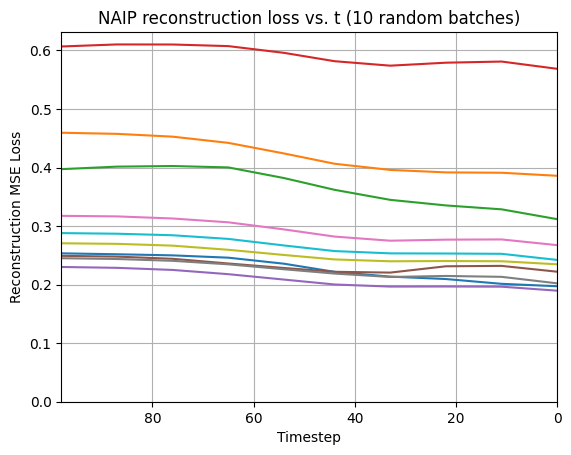

In [10]:
num_batches = 10
naip_reconstruction_loss_arr = []

run.net.eval()
with torch.no_grad():
  for n in range(num_batches):
    naip_x1, naip_x0 = next(iter(naip_loader))
    naip_x1, naip_x0 = naip_x1.to(DEVICE), naip_x0.to(DEVICE)

    naip_xs, naip_pred_x0s = run.ddpm_sampling(opt, naip_x1, clip_denoise=opt.clip_denoise, verbose=False)
    naip_pred_x0s = naip_pred_x0s.to(opt.device)
    print(naip_pred_x0s.shape)

    # plot latent gt vs pred latent spaces
    # if (n == 0):
    #     batch_item = 0
    #     naip_x0_hat = naip_pred_x0s[:, -1]
    #     plot_latent_space(naip_x1[batch_item])
    #     plot_latent_space(naip_x0[batch_item])
    #     plot_latent_space(naip_x0_hat[batch_item])
    #     plot_one_latent_distribution(naip_x1[batch_item].cpu())
    #     plot_one_latent_distribution(naip_x0[batch_item].cpu())
    #     plot_one_latent_distribution(naip_x0_hat[batch_item].cpu())


    #     print(f"reconstruction loss is {F.mse_loss(naip_x0_hat, naip_x0)}")
    #     naip_x1_stats = torch.std_mean(naip_x1[batch_item])
    #     naip_x0_stats = torch.std_mean(naip_x0[batch_item])
    #     naip_x0_hat_stats = torch.std_mean(naip_x0_hat[batch_item])
    #     print(f"naip_x1 stats: mean={naip_x1_stats[1]} std={naip_x1_stats[0]} min={naip_x1.min()} max={naip_x1.max()}")
    #     print(f"naip_x0 stats: mean={naip_x0_stats[1]} std={naip_x0_stats[0]} min={naip_x0.min()} max={naip_x0.max()}")
    #     print(f"naip_x0_hat stats: mean={naip_x0_hat_stats[1]} std={naip_x0_hat_stats[0]} min={naip_x0_hat.min()} max={naip_x0_hat.max()}")
    #     break

    B, numSteps, C, H, W = naip_pred_x0s.shape
    naip_loss_per_step = []

    for s in range(numSteps):
      # pred_x0s[:,s] is (B, C, H, W)
      naip_reconstruction_loss = F.mse_loss(naip_pred_x0s[:,s], naip_x0)
      naip_loss_per_step.append(naip_reconstruction_loss.item())

    naip_loss_per_step.reverse()

    # print(f"naip_loss_per_step (clean to noisy): {naip_loss_per_step}")

    naip_reconstruction_loss_arr.append(naip_loss_per_step)

plt.figure()
plt.gca().invert_xaxis()
for n in range(num_batches):
    plt.plot(LOG_STEPS, naip_reconstruction_loss_arr[n])
plt.xlabel("Timestep")
plt.ylabel("Reconstruction MSE Loss")
plt.xlim(LOG_STEPS[-1], LOG_STEPS[0])
plt.ylim(0)
plt.title(f"NAIP reconstruction loss vs. t ({num_batches} random batches)")
plt.grid(True)
plt.show()

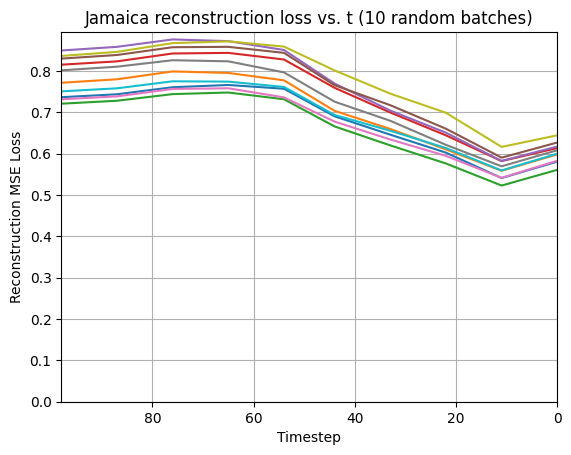

In [11]:
num_batches = 10
jamaica_reconstruction_loss_arr = []

run.net.eval()
with torch.no_grad():
  for n in range(num_batches):
    jamaica_x1, jamaica_x0 = next(iter(jamaica_loader))
    jamaica_x1, jamaica_x0 = jamaica_x1.to(DEVICE), jamaica_x0.to(DEVICE)

    jamaica_xs, jamaica_pred_x0s = run.ddpm_sampling(opt, jamaica_x1, clip_denoise=opt.clip_denoise, verbose=False)
    jamaica_pred_x0s = jamaica_pred_x0s.to(opt.device)

    B, numSteps, C, H, W = jamaica_pred_x0s.shape
    jamaica_loss_per_step = []

    for s in range(numSteps):
      # pred_x0s[:,s] is (B, C, H, W)
      jamaica_reconstruction_loss = F.mse_loss(jamaica_pred_x0s[:,s], jamaica_x0)
      jamaica_loss_per_step.append(jamaica_reconstruction_loss.item())

    jamaica_loss_per_step.reverse()

    # print(f"jamaica_loss_per_step (clean to noisy): {jamaica_loss_per_step}")

    jamaica_reconstruction_loss_arr.append(jamaica_loss_per_step)

plt.figure()
plt.gca().invert_xaxis()
for n in range(num_batches):
    plt.plot(LOG_STEPS, jamaica_reconstruction_loss_arr[n])
plt.xlabel("Timestep")
plt.ylabel("Reconstruction MSE Loss")
plt.xlim(LOG_STEPS[-1], LOG_STEPS[0])
plt.ylim(0)
plt.title(f"Jamaica reconstruction loss vs. t ({num_batches} random batches)")
plt.grid(True)
plt.show()